In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Veri setini yükleme ve hazırlama
df = pd.read_excel("rainfall-and-daily-consumption-data-on-istanbul-dams.xlsx")
df = df[['Tarih', 'İstanbul günlük tüketim(m³/gün)']]
df = df.set_index("Tarih")
df.index = pd.to_datetime(df.index)
df['İstanbul günlük tüketim(m³/gün)'] = df['İstanbul günlük tüketim(m³/gün)'] // 100
df['İstanbul günlük tüketim(m³/gün)'] = df['İstanbul günlük tüketim(m³/gün)'].astype(float)
df['İstanbul günlük tüketim(m³/gün)'] = np.log(df['İstanbul günlük tüketim(m³/gün)'])

# Eğitim ve test setlerini oluşturma
train_size = int(len(df) * 0.80)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Veriyi normalize etme
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Normalize edilmiş verileri DataFrame'e geri döndürme
train_scaled_df = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test_scaled_df = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

# SARIMAX modelini oluşturma
order = (1, 1, 1)  # (p, d, q) değerleri
seasonal_order = (1, 1, 1, 7)  # (P, D, Q, s) değerleri
sarimax_model = SARIMAX(train_scaled_df['İstanbul günlük tüketim(m³/gün)'], order=order, seasonal_order=seasonal_order)
sarimax_model_fit = sarimax_model.fit(disp=False)
print(sarimax_model_fit.summary())

# Test seti üzerinde tahmin yapma
predictions_scaled = sarimax_model_fit.predict(start=test_scaled_df.index[0], end=test_scaled_df.index[-1])

# Tahminleri orijinal ölçeğe döndürme
# Test verilerini orijinal ölçeğe dönüştürme
predictions_scaled = predictions_scaled.values.reshape(-1, 1)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, test_scaled_df.drop(columns=['İstanbul günlük tüketim(m³/gün)']).values], axis=1))[:, 0]

# Test verilerini orijinal ölçeğe dönüştürme
test_orig = scaler.inverse_transform(test_scaled_df)

# Hataları hesaplama
mse = mean_squared_error(test_orig[:, 0], predictions)
print("Mean Squared Error (MSE): {:.4f}".format(mse))

rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))

mae = mean_absolute_error(test_orig[:, 0], predictions)
print("Mean Absolute Error (MAE): {:.4f}".format(mae))

mape = mean_absolute_percentage_error(test_orig[:, 0], predictions)
print("Mean Absolute Percentage Error (MAPE): {:.4f}".format(mape * 100))

C:\Users\DOGUKAN\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\DOGUKAN\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:     İstanbul günlük tüketim(m³/gün)   No. Observations:                 3771
Model:               SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                5880.354
Date:                             Sun, 02 Jun 2024   AIC                         -11750.707
Time:                                     16:09:16   BIC                         -11719.542
Sample:                                 01-01-2011   HQIC                        -11739.626
                                      - 04-28-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5476      0.014     38.193      0.000       0.519       0.576
ma.L1         -0.8992      

In [2]:
predictions

array([10.21563532, 10.21519578, 10.21934929, 10.23175414, 10.22277547,
       10.20905613, 10.2116457 , 10.21732   , 10.21450054, 10.22070095,
       10.23531021, 10.2221443 , 10.20863365, 10.21219722, 10.21767416,
       10.2146442 , 10.22100609, 10.2357933 , 10.2222792 , 10.20878453,
       10.21242788, 10.21788814, 10.21484059, 10.22121571, 10.23601755,
       10.22247466, 10.2089813 , 10.21263123, 10.21809011, 10.2150411 ,
       10.22141731, 10.23622036, 10.22267508, 10.20918183, 10.2128323 ,
       10.21829107, 10.21524194, 10.22161824, 10.23642139, 10.22287592,
       10.20938267, 10.21303319, 10.21849194, 10.21544281, 10.22181911,
       10.23662227, 10.22307678, 10.20958354, 10.21323406, 10.21869281,
       10.21564368, 10.22201998, 10.23682314, 10.22327765, 10.20978441,
       10.21343493, 10.21889368, 10.21584455, 10.22222085, 10.23702401,
       10.22347852, 10.20998528, 10.2136358 , 10.21909455, 10.21604542,
       10.22242172, 10.23722488, 10.22367939, 10.21018615, 10.21

In [3]:
pred8=predictions

In [4]:
len(pred8)

943

In [5]:
pred8=np.array(pred8)

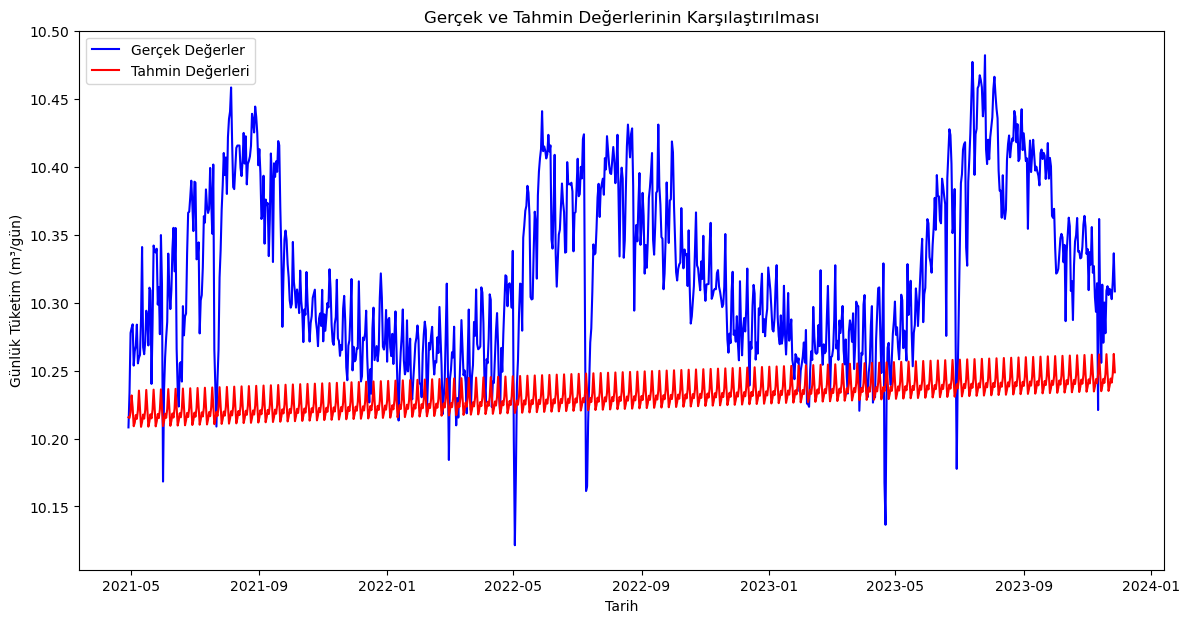

In [7]:
# Gerçek ve tahmin değerleri birleştirme
results = pd.DataFrame({'Tarih': test.index, 'Gerçek': test_orig.flatten(), 'Tahmin': predictions.flatten()})
results = results.set_index('Tarih')

# Görselleştirme
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Gerçek'], label='Gerçek Değerler', color='blue')
plt.plot(results.index, results['Tahmin'], label='Tahmin Değerleri', color='red')
plt.title('Gerçek ve Tahmin Değerlerinin Karşılaştırılması')
plt.xlabel('Tarih')
plt.ylabel('Günlük Tüketim (m³/gün)')
plt.legend()
plt.show()